In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier

import lightgbm as lgb

from time import time
from tqdm import tqdm_notebook as tqdm
pd.set_option("max_columns", 1000)

path = r"C:\Users\Administrator\Desktop\Participants_Data"

os.chdir(path)


In [2]:
train_data = pd.read_excel('Data_Train.xlsx')
test_data= pd.read_excel('Data_Test.xlsx')

#Combining train and test
test_data['Delivery_Time'] = None
merge_data = pd.concat([train_data, test_data]).reset_index(drop = True)

print(train_data.shape, test_data.shape)


(11094, 9) (2774, 9)


In [3]:
test_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_2842,"Mico Layout, Stage 2, BTM Layout,Bangalore","North Indian, Chinese, Assamese",₹350,₹50,4.2,361,225,None
1,ID_730,"Mico Layout, Stage 2, BTM Layout,Bangalore","Biryani, Kebab",₹100,₹50,NEW,-,-,None
2,ID_4620,"Sector 1, Noida",Fast Food,₹100,₹50,3.6,36,16,None
3,ID_5470,"Babarpur, New Delhi, Delhi","Mithai, North Indian, Chinese, Fast Food, Sout...",₹200,₹50,3.6,66,33,None
4,ID_3249,"Sector 1, Noida","Chinese, Fast Food",₹150,₹50,2.9,38,14,None


In [4]:
merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11,4,30 minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",₹150,₹50,3.6,99,30,65 minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",₹250,₹99,3.7,176,95,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",₹200,₹99,3.2,521,235,65 minutes


In [5]:
print('Average Cost unique value: ',merge_data.Average_Cost.unique())
print('Rating unique value: ',merge_data.Rating.unique())
print(merge_data.shape)

Average Cost unique value:  ['₹200' '₹100' '₹150' '₹250' '₹650' '₹350' '₹800' '₹50' '₹400' '₹600'
 '₹300' '₹750' '₹450' '₹550' '₹1,000' '₹500' '₹900' '₹1,200' '₹950' '₹850'
 '₹700' '₹1,150' 'for' '₹1,100' '₹1,400' '₹2,050']
Rating unique value:  ['3.5' '3.6' '3.7' '3.2' '3.8' '4.0' '3.9' '4.2' '-' '2.8' '3.0' '3.3'
 '3.1' '4.7' '3.4' '4.1' 'NEW' '2.9' '4.6' '4.3' '2.6' '4.5' '4.4' '4.8'
 '2.4' '2.7' '2.5' 'Opening Soon' '2.2' '4.9' '2.3' '2.1'
 'Temporarily Closed']
(13868, 9)


In [6]:
merge_data = merge_data.loc[merge_data['Average_Cost'] != 'for',:]
merge_data = merge_data.loc[merge_data['Rating'] != 'Temporarily Closed',:]
print(merge_data.shape)

(13865, 9)


In [7]:
# Replacing the rupees 
merge_data['Average_Cost'] = merge_data.Average_Cost.str.replace('₹|,', '').astype('int')
merge_data['Minimum_Order'] = merge_data.Minimum_Order.str.replace('₹|,', '').astype('int')
print(merge_data.dtypes)

Restaurant       object
Location         object
Cuisines         object
Average_Cost      int32
Minimum_Order     int32
Rating           object
Votes            object
Reviews          object
Delivery_Time    object
dtype: object


In [8]:
print('Rating unique value: ',merge_data.Rating.unique())

Rating unique value:  ['3.5' '3.6' '3.7' '3.2' '3.8' '4.0' '3.9' '4.2' '-' '2.8' '3.0' '3.3'
 '3.1' '4.7' '3.4' '4.1' 'NEW' '2.9' '4.6' '4.3' '2.6' '4.5' '4.4' '4.8'
 '2.4' '2.7' '2.5' 'Opening Soon' '2.2' '4.9' '2.3' '2.1']


In [9]:
merge_data['restaurant_type'] = np.where(merge_data.Rating == '-', 3, np.where(merge_data.Rating == 'Opening Soon', 2, 
                                                                         np.where(merge_data.Rating == 'NEW', 1, 0)))

merge_data.Rating[merge_data.Rating.isin(['-', 'Opening Soon', 'NEW'])] = 3.6
merge_data.Rating = merge_data.Rating.astype('float')
merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12,4,30 minutes,0
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11,4,30 minutes,0
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99,30,65 minutes,0
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176,95,30 minutes,0
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521,235,65 minutes,0


In [10]:
merge_data.Votes[merge_data.Votes.isin(['-'])] = 226
merge_data.Votes = merge_data.Votes.astype('float')

merge_data.Reviews[merge_data.Reviews.isin(['-'])] = 111
merge_data.Reviews = merge_data.Reviews.astype('float')

In [11]:
# Resetting the index
merge_data = merge_data.reset_index(drop = True)
merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30 minutes,0
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30 minutes,0
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65 minutes,0
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30 minutes,0
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65 minutes,0


# Feature Engineering

In [12]:
# votes, reviews, rating multiple
merge_data['votes_review_rating'] = merge_data.Votes*merge_data.Reviews*merge_data.Rating
merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30 minutes,0,168.0
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30 minutes,0,154.0
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65 minutes,0,10692.0
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30 minutes,0,61864.0
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65 minutes,0,391792.0


In [13]:
merge_data['Cusine_len'] = merge_data.Cuisines.apply(lambda x : len(x.replace(" ", " ").split(",")))

merge_data['city'] = merge_data.Location.apply(lambda x : np.char.strip(x.split(','))[-1])

In [14]:
print('city unique value: ',merge_data.city.unique())
merge_data.head()

city unique value:  ['Pune' 'Marathalli' 'Mumbai Central' 'Noida' 'Whitefield'
 'Delhi University-GTB Nagar' 'Maharashtra' 'Timarpur' 'Kolkata'
 'Mumbai CST Area' 'Pune University' 'Bangalore' 'Gurgoan' 'Begumpet'
 'Majestic' 'India Gate' 'Hyderabad' 'Gurgaon' 'Delhi Cantt.' 'Mumbai'
 'Delhi' 'Electronic City']


,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,city
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30 minutes,0,168.0,5,Pune
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30 minutes,0,154.0,2,Marathalli
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65 minutes,0,10692.0,3,Mumbai Central
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30 minutes,0,61864.0,3,Noida
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65 minutes,0,391792.0,2,Whitefield


# Types of Restaurant

In [15]:
restaurant_type_cnt = merge_data.groupby('restaurant_type')['Restaurant'].count().reset_index()

restaurant_type_cnt

,restaurant_type,Restaurant
0,0,11398
1,1,957
2,2,14
3,3,1496


In [16]:
from matplotlib import pyplot as plt

plt.bar(restaurant_type_cnt['restaurant_type'], restaurant_type_cnt['Restaurant'], width= .4)

plt.xlabel('Restaurant')

plt.ylabel('Restaurant count')

plt.title('Types of Restaurants')

plt.show()

<Figure size 640x480 with 1 Axes>

# Relation between Rating and Delivery Time

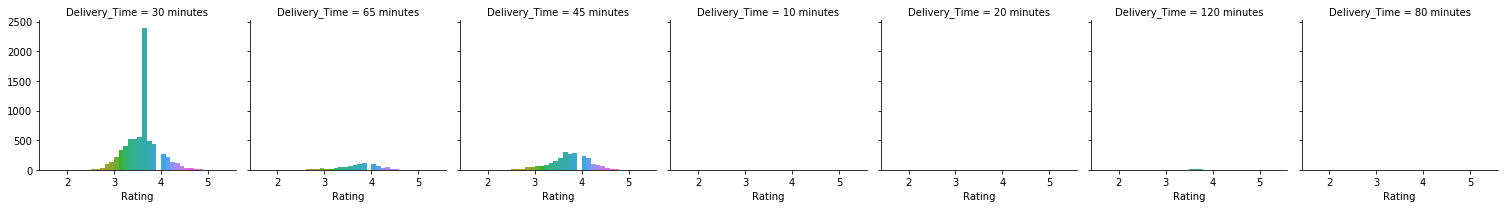

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.FacetGrid(merge_data, col = "Delivery_Time", hue = "Rating")
g.map(plt.hist, "Rating")

plt.show()

# Understanding relation between Rating, Votes and Reviews

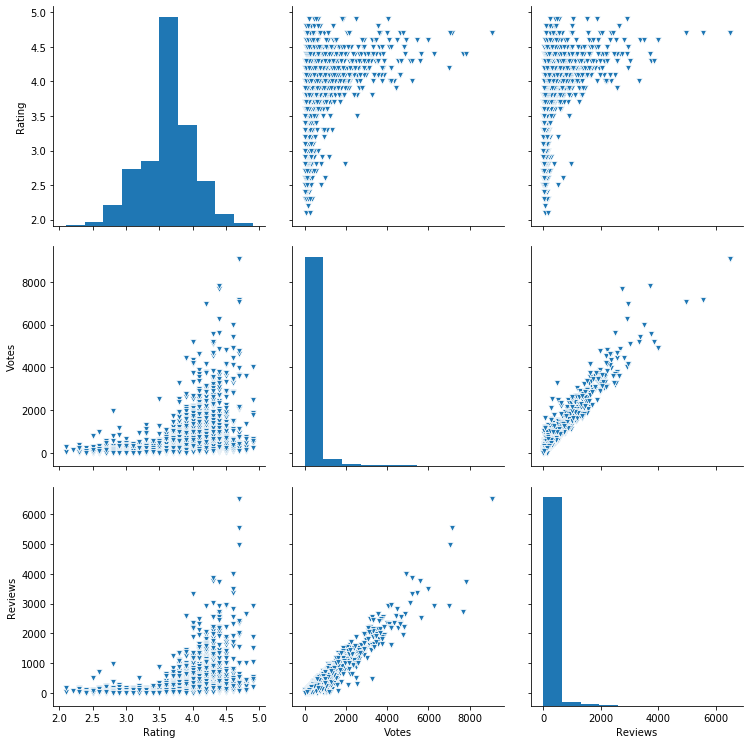

In [18]:
sns.pairplot(merge_data,vars=['Rating','Votes','Reviews'], markers='v', height=3.5, palette="Blues_d")

# Top 10 restaurants based on Rating

In [19]:
rating_wise_restaurant = merge_data.groupby(['Restaurant'])['Rating'].sum().reset_index().sort_values(by = 'Rating', ascending = False)

rating_wise_restaurant = rating_wise_restaurant.head(10)

rating_wise_restaurant

,Restaurant,Rating
1650,ID_2483,94.1
6872,ID_7184,92.2
6995,ID_7295,89.6
4062,ID_4654,87.9
7501,ID_7750,77.8
5044,ID_5538,77.5
159,ID_1140,77.4
235,ID_1209,77.2
1449,ID_2301,72.0
8347,ID_8511,69.2


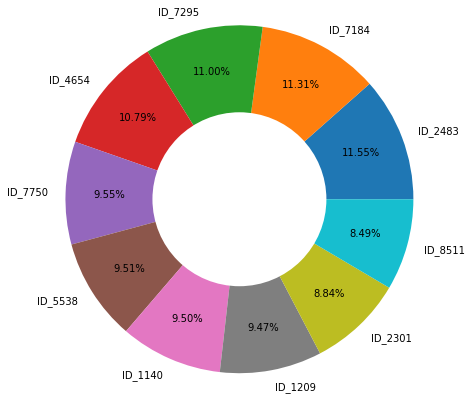

In [20]:
plt.pie(rating_wise_restaurant['Rating'], labels=rating_wise_restaurant['Restaurant'], autopct="%.2f%%",radius=2,
       pctdistance=.75)

centre_circle = plt.Circle((0,0), 1, fc = 'white')

fig = plt.gcf()

fig.gca().add_artist(centre_circle)

plt.show()

# Cleaning Multi-value cell of Location column

In [21]:
actual_city = {'Noida' : 'Noida', 
               'Gurgaon' : 'Gurgoan',
               'Gurgoan' : 'Gurgoan',
               'Mumbai CST Area' : 'Mumbai',
               'Mumbai Central' : 'Mumbai',
               'Mumbai' : 'Mumbai',
               'Pune' : 'Pune',
               'Maharashtra' : 'Pune',
               'Pune University' : 'Pune',
               'Timarpur' : 'Delhi',
               'Delhi' : 'Delhi',
               'Delhi Cantt.' : 'Delhi',
               'Delhi University-GTB Nagar' : 'Delhi',
               'India Gate' : 'Delhi',
               'Whitefield' : 'Banglore', 
               'Marathalli' : 'Banglore',
               'Majestic' : 'Banglore',
               'Bangalore' : 'Banglore',
               'Electronic City' : 'Banglore',
               'Hyderabad' : 'Hyderabad',
               'Begumpet' : 'Hyderabad',
               'Kolkata' : 'Kolkata'
               }

merge_data['new_city'] = merge_data[['city']].applymap(actual_city.get)
merge_data.drop(['city'], axis = 1, inplace = True)

merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,new_city
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30 minutes,0,168.0,5,Pune
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30 minutes,0,154.0,2,Banglore
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65 minutes,0,10692.0,3,Mumbai
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30 minutes,0,61864.0,3,Noida
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65 minutes,0,391792.0,2,Banglore


# Highest food ordering cities

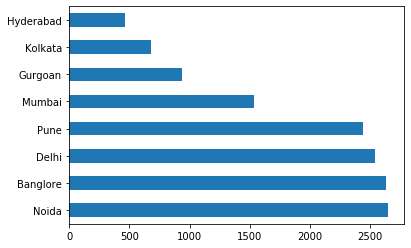

In [22]:
merge_data['new_city'].value_counts().plot(kind='barh')

In [23]:
merge_data.isnull().sum()

Restaurant                0
Location                  0
Cuisines                  0
Average_Cost              0
Minimum_Order             0
Rating                    0
Votes                     0
Reviews                   0
Delivery_Time          2774
restaurant_type           0
votes_review_rating       0
Cusine_len                0
new_city                  0
dtype: int64

# Deriving new time column

In [24]:
merge_data[['new_time','new_time_1']] = merge_data.Delivery_Time.str.split(" ",expand=True,)
merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,new_city,new_time,new_time_1
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30 minutes,0,168.0,5,Pune,30,minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30 minutes,0,154.0,2,Banglore,30,minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65 minutes,0,10692.0,3,Mumbai,65,minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30 minutes,0,61864.0,3,Noida,30,minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65 minutes,0,391792.0,2,Banglore,65,minutes


In [25]:
merge_data['new_time'] = merge_data.new_time.astype(float)

# Delivery Time Analysis

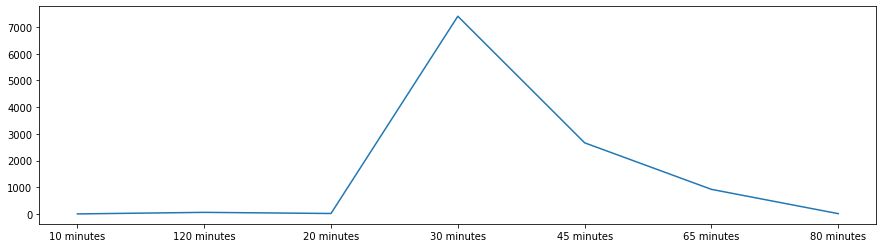

In [26]:
plt.figure(figsize=(15,4))
plt.plot(merge_data['Delivery_Time'].value_counts().sort_index())


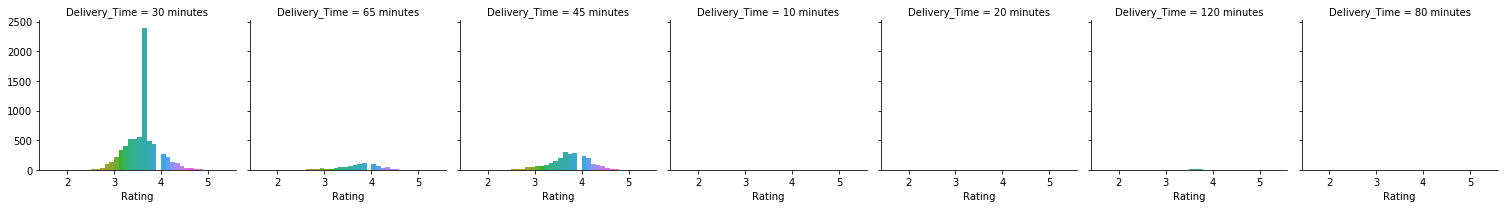

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.FacetGrid(merge_data, col = "Delivery_Time", hue = "Rating")
g.map(plt.hist, "Rating")
plt.show()

# City-wise Delivery time Analysis

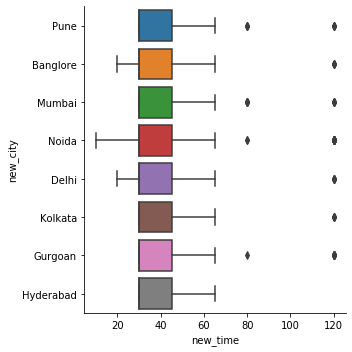

In [28]:
sns.catplot(x="new_time", y="new_city",  kind="box", data=merge_data);

# Minimum Order Analysis

Text(0.5, 0, 'Min Order Cost(Rs/-)')

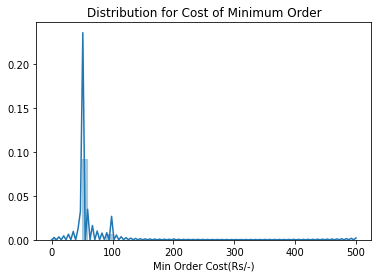

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(merge_data['Minimum_Order'], hist=True)
plt.title('Distribution for Cost of Minimum Order')
plt.xlabel('Min Order Cost(Rs/-)')

# Average Cost Analysis

Text(0.5, 0, 'Average Cost (Rs/-)')

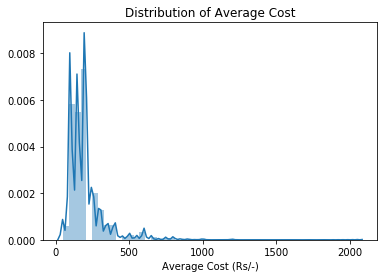

In [30]:
sns.distplot(merge_data['Average_Cost'], hist=True)
plt.title('Distribution of Average Cost')
plt.xlabel('Average Cost (Rs/-)')

In [31]:
merge_data = merge_data.drop(['new_time_1'], axis=1)
merge_data = merge_data.drop(['new_time'], axis=1)

In [32]:
#Adding average restaurant data
Average_restaurant_rating = merge_data.loc[merge_data.Rating != -999 ,:].groupby('Restaurant')['Rating'].agg([('avg_restaurant_Rating', 'mean')
                                                                                                       ]).reset_index()
Average_restaurant_Review = merge_data.loc[merge_data.Rating != -999 ,:].groupby('Restaurant')['Reviews'].agg([('avg_restaurant_Reviews', 'mean')
                                                                                                         ]).reset_index()
Average_restaurant_Votes = merge_data.loc[merge_data.Rating != -999 ,:].groupby('Restaurant')['Votes'].agg([('avg_restaurant_Votes', 'mean')
                                                                                                      ]).reset_index()

merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,new_city
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30 minutes,0,168.0,5,Pune
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30 minutes,0,154.0,2,Banglore
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65 minutes,0,10692.0,3,Mumbai
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30 minutes,0,61864.0,3,Noida
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65 minutes,0,391792.0,2,Banglore


In [33]:
merge_data = pd.merge(merge_data, Average_restaurant_rating, how = 'left', left_on = 'Restaurant', right_on = 'Restaurant')
merge_data = pd.merge(merge_data, Average_restaurant_Review, how = 'left', left_on = 'Restaurant', right_on = 'Restaurant')
merge_data = pd.merge(merge_data, Average_restaurant_Votes, how = 'left', left_on = 'Restaurant', right_on = 'Restaurant')


merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,new_city,avg_restaurant_Rating,avg_restaurant_Reviews,avg_restaurant_Votes
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30 minutes,0,168.0,5,Pune,3.500000,4.000000,12.000000
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30 minutes,0,154.0,2,Banglore,3.283333,43.166667,88.166667
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65 minutes,0,10692.0,3,Mumbai,3.600000,30.000000,99.000000
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30 minutes,0,61864.0,3,Noida,3.700000,95.000000,176.000000
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65 minutes,0,391792.0,2,Banglore,3.200000,235.000000,521.000000


In [34]:
merge_data.isnull().sum()

Restaurant                   0
Location                     0
Cuisines                     0
Average_Cost                 0
Minimum_Order                0
Rating                       0
Votes                        0
Reviews                      0
Delivery_Time             2774
restaurant_type              0
votes_review_rating          0
Cusine_len                   0
new_city                     0
avg_restaurant_Rating        0
avg_restaurant_Reviews       0
avg_restaurant_Votes         0
dtype: int64

In [35]:
columns = ['avg_restaurant_Rating', 'avg_restaurant_Reviews', 'avg_restaurant_Votes']

merge_data[columns] = merge_data[columns].fillna(-999)
           
merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,new_city,avg_restaurant_Rating,avg_restaurant_Reviews,avg_restaurant_Votes
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30 minutes,0,168.0,5,Pune,3.500000,4.000000,12.000000
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30 minutes,0,154.0,2,Banglore,3.283333,43.166667,88.166667
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65 minutes,0,10692.0,3,Mumbai,3.600000,30.000000,99.000000
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30 minutes,0,61864.0,3,Noida,3.700000,95.000000,176.000000
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65 minutes,0,391792.0,2,Banglore,3.200000,235.000000,521.000000


In [36]:
#merge_data.Restaurant.value_counts() 

In [37]:
# Total restaurant branches
merge_data['total_branches'] = merge_data.groupby(['Restaurant']).new_city.transform('count')
merge_data.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,new_city,avg_restaurant_Rating,avg_restaurant_Reviews,avg_restaurant_Votes,total_branches
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30 minutes,0,168.0,5,Pune,3.500000,4.000000,12.000000,1
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30 minutes,0,154.0,2,Banglore,3.283333,43.166667,88.166667,6
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65 minutes,0,10692.0,3,Mumbai,3.600000,30.000000,99.000000,3
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30 minutes,0,61864.0,3,Noida,3.700000,95.000000,176.000000,2
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65 minutes,0,391792.0,2,Banglore,3.200000,235.000000,521.000000,1


In [38]:
available_cuisines = list(merge_data.Cuisines.apply(lambda x : x.split(",")))
#available_cuisines

In [39]:
merged = list(itertools.chain.from_iterable(available_cuisines))

# Filling the Cusines OHE columns

In [40]:
def determine_unique_cuisines():
    cuisines_list = [val for val in merge_data['Cuisines'].str.split(",")]
    cuisines_list = [",".join([v.strip() for v in val]) for val in cuisines_list]
    unique_cuisines = set(",".join(cuisines_list).split(","))
    print("total unique cuisines {}".format(len(unique_cuisines)))
    print("unique cuisines are {}".format(unique_cuisines))

    return unique_cuisines

unique_cuisines =  determine_unique_cuisines()

total unique cuisines 101
unique cuisines are {'Chettinad', 'Iranian', 'Kashmiri', 'Israeli', 'Turkish', 'Bihari', 'Healthy Food', 'Belgian', 'American', 'Bakery', 'French', 'Raw Meats', 'Burger', 'South Indian', 'Bubble Tea', 'Nepalese', 'Assamese', 'Desserts', 'Japanese', 'Odia', 'European', 'German', 'Vietnamese', 'Tamil', 'South American', 'Parsi', 'Goan', 'Paan', 'Mughlai', 'Arabian', 'Tibetan', 'Thai', 'Roast Chicken', 'Street Food', 'Hyderabadi', 'Poké', 'Cafe', 'Finger Food', 'Bohri', 'Gujarati', 'Beverages', 'Korean', 'Kerala', 'North Eastern', 'BBQ', 'Awadhi', 'Mangalorean', 'Sri Lankan', 'Italian', 'Lebanese', 'Burmese', 'Afghan', 'Kebab', 'Konkan', 'Mishti', 'Tex-Mex', 'Salad', 'Maharashtrian', 'Asian', 'Biryani', 'Andhra', 'Bar Food', 'Ice Cream', 'Chinese', 'Fast Food', 'Cantonese', 'Middle Eastern', 'Sushi', 'Spanish', 'African', 'Continental', 'Mexican', 'Lucknowi', 'Mithai', 'Malwani', 'Coffee', 'Malaysian', 'Seafood', 'Mediterranean', 'Portuguese', 'Brazilian', 'Hot d

In [41]:
print("Start training....")
tStart = time()

cuisine_vals_list = []
for i, row in tqdm(merge_data.iterrows()):
    location_dict = {k:0 for k in unique_cuisines}
    for k in row['Cuisines'].split(","):
        location_dict[k.strip()] = 1
    cuisine_vals_list.append(location_dict)
    
print("Training time: ", round(time()-tStart, 3), "s")
    
merge_data = merge_data.drop("Cuisines", axis=1)
merge_data = pd.concat((merge_data, pd.DataFrame(cuisine_vals_list).fillna(0).astype(np.int8)), axis=1)
merge_data.head()


Start training....



Training time:  2.87 s


,Restaurant,Location,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,new_city,avg_restaurant_Rating,avg_restaurant_Reviews,avg_restaurant_Votes,total_branches,Afghan,African,American,Andhra,Arabian,Asian,Assamese,Awadhi,BBQ,Bakery,Bangladeshi,Bar Food,Belgian,Bengali,Beverages,Bihari,Biryani,Bohri,Brazilian,Bubble Tea,Burger,Burmese,Cafe,Cantonese,Charcoal Chicken,Chettinad,Chinese,Coffee,Continental,Desserts,European,Fast Food,Finger Food,French,Frozen Yogurt,German,Goan,Greek,Gujarati,Healthy Food,Hot dogs,Hyderabadi,Ice Cream,Indian,Indonesian,Iranian,Israeli,Italian,Japanese,Juices,Kashmiri,Kebab,Kerala,Konkan,Korean,Lebanese,Lucknowi,Maharashtrian,Malaysian,Malwani,Mangalorean,Mediterranean,Mexican,Middle Eastern,Mishti,Mithai,Modern Indian,Momos,Mughlai,Naga,Nepalese,North Eastern,North Indian,Odia,Paan,Parsi,Pizza,Poké,Portuguese,Rajasthani,Raw Meats,Roast Chicken,Rolls,Salad,Sandwich,Seafood,South American,South Indian,Spanish,Sri Lankan,Steak,Street Food,Sushi,Tamil,Tea,Tex-Mex,Thai,Tibetan,Turkish,Vietnamese,Wraps
0,ID_6321,"FTI College, Law College Road, Pune",200,50,3.5,12.0,4.0,30 minutes,0,168.0,5,Pune,3.500000,4.000000,12.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,ID_2882,"Sector 3, Marathalli",100,50,3.5,11.0,4.0,30 minutes,0,154.0,2,Banglore,3.283333,43.166667,88.166667,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ID_1595,Mumbai Central,150,50,3.6,99.0,30.0,65 minutes,0,10692.0,3,Mumbai,3.600000,30.000000,99.000000,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,ID_5929,"Sector 1, Noida",250,99,3.7,176.0,95.0,30 minutes,0,61864.0,3,Noida,3.700000,95.000000,176.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ID_6123,"Rmz Centennial, I Gate, Whitefield",200,99,3.2,521.0,235.0,65 minutes,0,391792.0,2,Banglore,3.200000,235.000000,521.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
merge_data.rename(columns = {'Poké' : 'Poke'}, inplace = True)
merge_data.tail()

,Restaurant,Location,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,new_city,avg_restaurant_Rating,avg_restaurant_Reviews,avg_restaurant_Votes,total_branches,Afghan,African,American,Andhra,Arabian,Asian,Assamese,Awadhi,BBQ,Bakery,Bangladeshi,Bar Food,Belgian,Bengali,Beverages,Bihari,Biryani,Bohri,Brazilian,Bubble Tea,Burger,Burmese,Cafe,Cantonese,Charcoal Chicken,Chettinad,Chinese,Coffee,Continental,Desserts,European,Fast Food,Finger Food,French,Frozen Yogurt,German,Goan,Greek,Gujarati,Healthy Food,Hot dogs,Hyderabadi,Ice Cream,Indian,Indonesian,Iranian,Israeli,Italian,Japanese,Juices,Kashmiri,Kebab,Kerala,Konkan,Korean,Lebanese,Lucknowi,Maharashtrian,Malaysian,Malwani,Mangalorean,Mediterranean,Mexican,Middle Eastern,Mishti,Mithai,Modern Indian,Momos,Mughlai,Naga,Nepalese,North Eastern,North Indian,Odia,Paan,Parsi,Pizza,Poke,Portuguese,Rajasthani,Raw Meats,Roast Chicken,Rolls,Salad,Sandwich,Seafood,South American,South Indian,Spanish,Sri Lankan,Steak,Street Food,Sushi,Tamil,Tea,Tex-Mex,Thai,Tibetan,Turkish,Vietnamese,Wraps
13860,ID_6342,Delhi University-GTB Nagar,100,50,3.6,226.0,111.0,None,1,90309.6,2,Delhi,3.600000,111.000000,226.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13861,ID_8495,"Mico Layout, Stage 2, BTM Layout,Bangalore",250,50,3.1,5.0,1.0,None,0,15.5,4,Banglore,3.418182,46.909091,98.090909,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13862,ID_7122,"Noorkhan Bazaar, Malakpet, Hyderabad",150,50,3.0,16.0,1.0,None,0,48.0,2,Hyderabad,3.000000,1.000000,16.000000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
13863,ID_2475,"D-Block, Sector 63, Noida",100,99,3.0,7.0,2.0,None,0,42.0,1,Noida,3.000000,2.000000,7.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13864,ID_1595,"Dockyard Road, Mumbai CST Area",150,50,3.6,99.0,30.0,None,0,10692.0,3,Mumbai,3.600000,30.000000,99.000000,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# Merging the cuisines OHE to the main dataframe

print(merge_data.shape)
merge_data = pd.merge(merge_data, cuisine_DF, left_index=True, right_index=True)
print(merge_data.shape)

In [43]:
#merge_data.dtypes

In [44]:
# Separating the numerical and categorical columns

target_column = 'Delivery_Time'

cat_columns = merge_data.select_dtypes(include = ['object']).columns.difference([target_column])
int_columns = merge_data.select_dtypes(include = ['int32']).columns

print(cat_columns)
print(int_columns)

Index(['Location', 'Restaurant', 'new_city'], dtype='object')
Index(['Average_Cost', 'Minimum_Order', 'restaurant_type'], dtype='object')


In [45]:
# Convert cat columns to numerics
LE = LabelEncoder()
merge_data[cat_columns] = merge_data[cat_columns].apply(lambda x : LE.fit_transform(x))

In [46]:
# Separating the training and testing data

train_df = merge_data.loc[~merge_data.Delivery_Time.isnull(), ]
test_df  = merge_data.loc[merge_data.Delivery_Time.isnull(), ]

# Label encode the dependent column to reverse encode later
Dep_encoder = LabelEncoder()
Dep_encoder.fit(train_df[target_column])
train_df[target_column] = Dep_encoder.transform(train_df[target_column])

print(train_df.shape, test_df.shape)
train_df.head()

(11091, 117) (2774, 117)


,Restaurant,Location,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,restaurant_type,votes_review_rating,Cusine_len,new_city,avg_restaurant_Rating,avg_restaurant_Reviews,avg_restaurant_Votes,total_branches,Afghan,African,American,Andhra,Arabian,Asian,Assamese,Awadhi,BBQ,Bakery,Bangladeshi,Bar Food,Belgian,Bengali,Beverages,Bihari,Biryani,Bohri,Brazilian,Bubble Tea,Burger,Burmese,Cafe,Cantonese,Charcoal Chicken,Chettinad,Chinese,Coffee,Continental,Desserts,European,Fast Food,Finger Food,French,Frozen Yogurt,German,Goan,Greek,Gujarati,Healthy Food,Hot dogs,Hyderabadi,Ice Cream,Indian,Indonesian,Iranian,Israeli,Italian,Japanese,Juices,Kashmiri,Kebab,Kerala,Konkan,Korean,Lebanese,Lucknowi,Maharashtrian,Malaysian,Malwani,Mangalorean,Mediterranean,Mexican,Middle Eastern,Mishti,Mithai,Modern Indian,Momos,Mughlai,Naga,Nepalese,North Eastern,North Indian,Odia,Paan,Parsi,Pizza,Poke,Portuguese,Rajasthani,Raw Meats,Roast Chicken,Rolls,Salad,Sandwich,Seafood,South American,South Indian,Spanish,Sri Lankan,Steak,Street Food,Sushi,Tamil,Tea,Tex-Mex,Thai,Tibetan,Turkish,Vietnamese,Wraps
0,5914,10,200,50,3.5,12.0,4.0,3,0,168.0,5,7,3.500000,4.000000,12.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2093,30,100,50,3.5,11.0,4.0,3,0,154.0,2,0,3.283333,43.166667,88.166667,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,663,19,150,50,3.6,99.0,30.0,5,0,10692.0,3,5,3.600000,30.000000,99.000000,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,5478,28,250,99,3.7,176.0,95.0,3,0,61864.0,3,6,3.700000,95.000000,176.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5694,26,200,99,3.2,521.0,235.0,5,0,391792.0,2,0,3.200000,235.000000,521.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
print('Delivery_Time unique value: ',merge_data.Delivery_Time.unique())

Delivery_Time unique value:  ['30 minutes' '65 minutes' '45 minutes' '10 minutes' '20 minutes'
 '120 minutes' '80 minutes' None]


In [48]:
indep = merge_data.columns.difference([target_column
                                    , 'total_branches'
                                    , 'Top_restaurant'
                                    ,'votes_review_rating'
                                   ] 
                                  )
#print(indep)

np.random.seed(100)
x_train, x_test, y_train, y_test = train_test_split(train_df[indep], train_df[target_column],test_size = 0.2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8872, 114), (8872,), (2219, 114), (2219,))

# Random Forest

# Model-1 Validation

In [49]:
print(y_test.unique())

print(y_train.unique())

[3 4 5 1 6 2]
[4 3 5 1 2 6 0]


In [50]:
np.random.seed(100)
RF = RandomForestClassifier(n_estimators = 280)

print("Start training....")
tStart = time()
RF.fit(x_train, y_train)
print("Training time: ", round(time()-tStart, 3), "s")
y_prediction = RF.predict(x_test)

print("Accuracy in %:", accuracy_score(y_test, y_prediction)*100)

y_pred_rf = pd.DataFrame(y_prediction)


cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix is:", cm, sep='\n')

Start training....
Training time:  7.231 s
Accuracy in %: 82.64984227129337
Confusion Matrix is:
[[   5    0    3    2    0    0]
 [   0    0    0    1    0    0]
 [   0    0 1420   87    2    0]
 [   0    0  162  347    4    0]
 [   1    0   41   80   61    0]
 [   0    0    1    1    0    1]]


In [51]:
gb =  GradientBoostingClassifier(n_estimators=280, random_state=0)

print("Start training....")
tStart = time()
gb.fit(x_train, y_train)
print("Training time: ", round(time()-tStart, 3), "s")


y_pred_gb = gb.predict(x_test)
print("Accuracy in %:", accuracy_score(y_test, y_pred_gb)*100)

y_pred_gb = pd.DataFrame(y_pred_gb)


cm = confusion_matrix(y_test, y_pred_gb)
print("Confusion Matrix is:", cm, sep='\n')

Start training....
Training time:  59.168 s
Accuracy in %: 76.34069400630915
Confusion Matrix is:
[[   0    0    0    0    0    0    0]
 [   0    5    0    4    1    0    0]
 [   0    0    0    1    0    0    0]
 [   3    1    1 1381  115    7    1]
 [   0    2    0  226  270   15    0]
 [   0    1    0   57   88   37    0]
 [   0    0    0    1    0    1    1]]


In [52]:
xgb =  XGBClassifier(n_estimators=280, random_state=100)

print("Start training....")
tStart = time()
xgb.fit(x_train, y_train)
print("Training time: ", round(time()-tStart, 3), "s")

y_pred_xgb = xgb.predict(x_test)
print("Accuracy in %:", accuracy_score(y_pred_xgb, y_test)*100)

y_pred_xgb = pd.DataFrame(y_pred_xgb)

cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix is:", cm, sep='\n')

Start training....
Training time:  108.954 s
Accuracy in %: 74.85353762956287
Confusion Matrix is:
[[   4    0    4    2    0    0]
 [   0    0    1    0    0    0]
 [   0    0 1378  127    4    0]
 [   4    0  239  261    9    0]
 [   2    0   60  103   18    0]
 [   0    0    1    1    1    0]]


In [53]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

clf = DecisionTreeClassifier(criterion= "entropy")

print("Start training....")
tStart = time()
clf.fit(x_train,y_train)
print("Training time: ", round(time()-tStart, 3), "s")

y_pred_clf = clf.predict(x_test)

print("Accuracy in %:", accuracy_score(y_test, y_pred_clf)*100)

y_pred_clf = pd.DataFrame(y_pred_gb)

cm = confusion_matrix(y_test, y_pred_clf)
print("Confusion Matrix is:", cm, sep='\n')

Start training....
Training time:  0.263 s
Accuracy in %: 74.13249211356468
Confusion Matrix is:
[[   0    0    0    0    0    0    0]
 [   0    5    0    4    1    0    0]
 [   0    0    0    1    0    0    0]
 [   3    1    1 1381  115    7    1]
 [   0    2    0  226  270   15    0]
 [   0    1    0   57   88   37    0]
 [   0    0    0    1    0    1    1]]


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

reg = LinearRegression()

print("Start training....")
tStart = time()
reg_model = reg.fit(x_train, y_train) 
print("Training time: ", round(time()-tStart, 3), "s")

y_pred_reg = reg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test,y_pred_reg))
r2 = r2_score(y_test,y_pred_reg)

print("Linear Regression's RMSE = ",rmse, " Linear Regression's R2 = ",r2)



Start training....
Training time:  0.083 s
Linear Regression's RMSE =  0.6119237756954117  Linear Regression's R2 =  0.1471314586909972


In [55]:
from sklearn.naive_bayes import  BernoulliNB

gnb = BernoulliNB()

print("Start training....")
tStart = time()
gnb.fit(x_train, y_train)
print("Training time: ", round(time()-tStart, 3), "s")

y_pred_gnb = gnb.predict(x_test)

print("Accuracy in %:", metrics.accuracy_score(y_test, y_pred_gnb)*100)

cm = confusion_matrix(y_test, y_pred_gnb)
print("Confusion Matrix is:", cm, sep='\n')

Start training....
Training time:  0.053 s
Accuracy in %: 67.82334384858044
Confusion Matrix is:
[[   1    0    8    1    0    0]
 [   0    0    1    0    0    0]
 [   4    2 1421   73    9    0]
 [   0    2  426   78    7    0]
 [   0    0  159   19    5    0]
 [   0    0    3    0    0    0]]


In [59]:
from sklearn.neighbors import KNeighborsClassifier 

print('Start training......')
tStart = time()
knn = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train) 
print("Training time: ", round(time()-tStart, 3), "s")
# accuracy on X_test 
accuracy = (knn.score(x_test, y_test)*100)
print (accuracy )
  
# creating a confusion matrix 
knn_predictions = knn.predict(x_test)  
cm = confusion_matrix(y_test, knn_predictions) 
print("Confusion Matrix is:", cm, sep='\n')

Start training......
Training time:  0.134 s
71.69896349707075
Confusion Matrix is:
[[   1    0    5    4    0    0]
 [   0    0    1    0    0    0]
 [   5    0 1372  117   15    0]
 [   1    1  301  186   24    0]
 [   1    0   92   58   32    0]
 [   0    0    3    0    0    0]]


In [57]:
from sklearn.svm import SVC
print('Start training......')
tStart = time()
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_train, y_train) 
print("Training time: ", round(time()-tStart, 3), "s")
svm_predictions = svm_model_linear.predict(x_test) 
  
# model accuracy for X_test   
accuracy_svm = svm_model_linear.score(x_test, y_test) 
print (accuracy_svm )
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions)
print("Confusion Matrix is:", cm, sep='\n')

Start training......
Training time:  3043.124 s
0.6967102298332583
Confusion Matrix is:
[[   1    0    6    2    1    0]
 [   0    0    1    0    0    0]
 [   1    1 1419   86    2    0]
 [   0    0  380  120   13    0]
 [   0    0  122   55    6    0]
 [   0    0    2    1    0    0]]


In [60]:
#precision_score(y_test, y_pred_rf, average='micro') 